# Contour Comparison

This notebook demonstrates how to compute compute contour comparison metrics using PlatiPy.

## Import Modules

In [41]:
try:
    import platipy
except:
    !pip install git+https://github.com/pyplati/platipy.git
    import platipy

from pathlib import Path

import pandas as pd
import SimpleITK as sitk

%matplotlib inline

from platipy.imaging.tests.data import download_and_extract_zip_file
from platipy.imaging.label.comparison import (
    compute_metric_dsc,
    compute_metric_hd,
    compute_metric_masd,
    compute_volume_metrics,
    compute_surface_metrics,
    compute_surface_dsc)
from platipy.imaging.visualisation.comparison import contour_comparison


## Download Test Data

This will download some sample data which was generated using the TCIA LCTSC dataset. The data contains some manual contours as well as auto contours.

> Note the contours in this dataset are for demonstration purposes only. No emphasis was placed on the quality of these contours.

In [14]:
data_path = Path("./data/contour_comparison_sample")

test_data_zip_url = "https://zenodo.org/record/7519243/files/platipy_contour_comparison_testdata.zip?download=1"

# Only download data if we haven't already downloaded the data previously
if len(list(data_path.glob("*/*.nii.gz"))) == 0:
    download_and_extract_zip_file(test_data_zip_url, data_path)

## Load data

Let's read in the data that we've downloaded

In [3]:
ct_image = sitk.ReadImage(str(data_path.joinpath("image", "CT.nii.gz")))

structure_names =["ESOPHAGUS", "HEART", "LUNG_L", "LUNG_R", "SPINALCORD"]

manual_structures = {
    s: sitk.ReadImage(str(data_path.joinpath("manual", f"{s}.nii.gz"))) for s in structure_names
}

auto_structures = {
    s: sitk.ReadImage(str(data_path.joinpath("auto", f"{s}.nii.gz"))) for s in structure_names
}

## Compute Metrics (for single structure)

The following cells demonstrate computing some common metrics between the manual and auto heart contour.

In [35]:
heart_dsc = compute_metric_dsc(manual_structures["HEART"], auto_structures["HEART"])
print(f"Dice Similarity Coefficient for Heart is: {heart_dsc:.2f}")

Dice Similarity Coefficient for Heart is: 0.88


In [33]:
heart_hd = compute_metric_hd(manual_structures["HEART"], auto_structures["HEART"])
print(f"Hausdorff distance for Heart is: {heart_hd:.2f}mm")

Hausdorff distance for Heart is: 11.92mm


In [39]:
heart_masd = compute_metric_masd(manual_structures["HEART"], auto_structures["HEART"])
print(f"Mean Absolute Surface for Heart is: {heart_masd:.2f}mm")

Mean Absolute Surface for Heart is: 4.04mm


In [34]:
heart_surface_dsc = compute_surface_dsc(manual_structures["HEART"], auto_structures["HEART"])
print(f"Surface DSC for Heart with a tau of 3mm is: {heart_surface_dsc:.2f}") # 3mm is the default value for tau

heart_surface_dsc = compute_surface_dsc(manual_structures["HEART"], auto_structures["HEART"], tau=5)
print(f"Surface DSC for Heart with a tau of 5mm is: {heart_surface_dsc:.2f}")

Surface DSC for Heart with a tau of 3mm is: 0.52
Surface DSC for Heart with a tau of 5mm is: 0.72


## Compute metrics (for multiple structures)

This example loops over each structure and computes some volume metrics using the `compute_volume_metrics` helper function. These are tracked in a list and finally converted to a pandas DataFrame.

In [43]:
result =  []
for structure_name in manual_structures:


    volume_dict = compute_volume_metrics(manual_structures[structure_name], auto_structures[structure_name])

    structure_dict = {
        "structure": structure_name,
        **volume_dict,
    }

    result.append(structure_dict)

df_metrics = pd.DataFrame(result)
df_metrics

,structure,DSC,volumeOverlap,fractionOverlap,truePositiveFraction,trueNegativeFraction,falsePositiveFraction,falseNegativeFraction
0,ESOPHAGUS,0.430794,9.861946,0.274530,0.357610,0.999905,0.000095,0.642390
1,HEART,0.879741,626.272202,0.785301,0.824823,0.999561,0.000439,0.175177
2,LUNG_L,0.895018,953.364372,0.809984,0.939151,0.998134,0.001866,0.060849
3,LUNG_R,0.905581,1330.435753,0.827454,0.934013,0.997875,0.002125,0.065987
4,SPINALCORD,0.647406,33.305168,0.478640,0.614366,0.999825,0.000175,0.385634


## Contour Comparison Function

You can use the `contour_comparison` function to prepare a visualisation and return a pandas DataFrame of commonly used metrics.

/Users/60126181/Work/python/platipy/platipy/imaging/visualisation/visualiser.py:1132: UserWarning: No contour levels were found within the data range.
  ax_ax.contour(


,STRUCTURE,DSC,MDA_mm,HD_mm,VOL_MANUAL_cm3,VOL_AUTO_cm3
0,ESOPHAGUS,0.430794,2.916249,14.344129,27.577400,18.207550
0,HEART,0.879741,4.037049,11.917850,759.281158,664.484024
0,LUNG_L,0.895018,2.023395,18.000000,1015.133858,1115.246773
0,LUNG_R,0.905581,2.319356,20.295816,1424.428940,1513.873100
0,SPINALCORD,0.647406,1.932112,14.218965,54.210663,48.677444


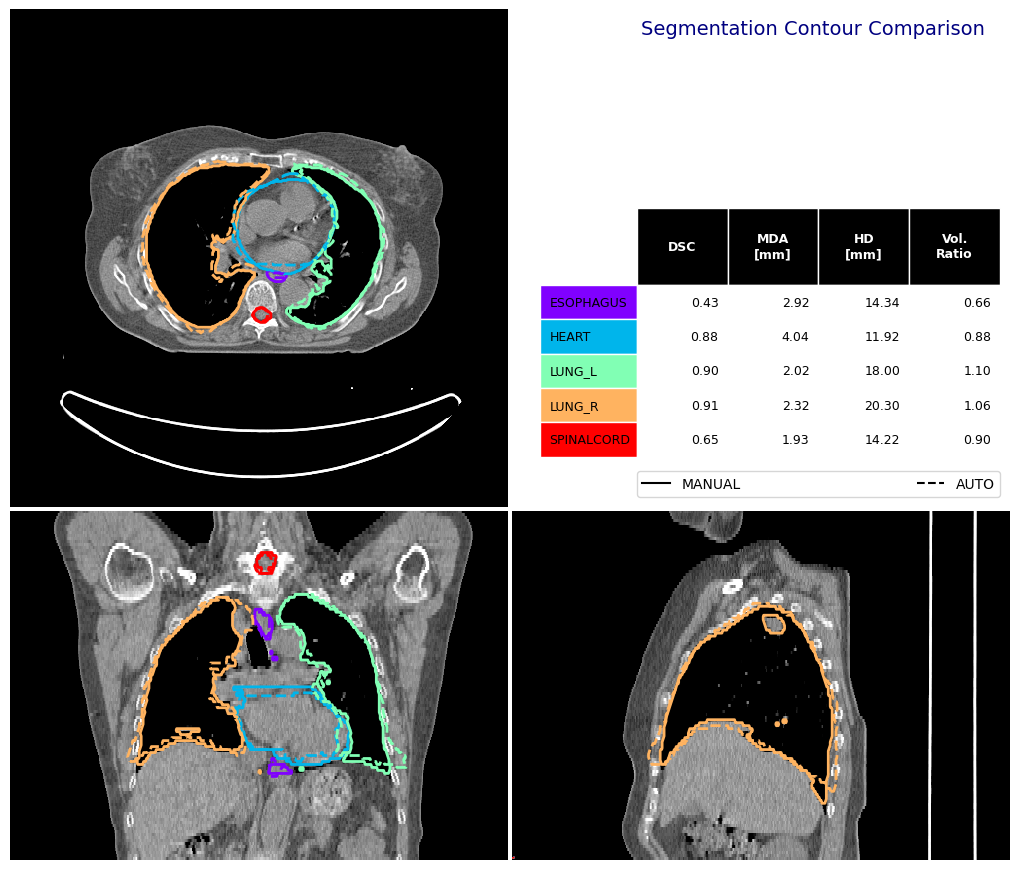

In [36]:
fig, df_mas = contour_comparison(
    img = ct_image,
    contour_dict_a = manual_structures,
    contour_dict_b = auto_structures,
    contour_label_a = "MANUAL",
    contour_label_b = "AUTO",
    title='Segmentation Contour Comparison',
    subtitle='',
    subsubtitle='',
)

df_mas

## Contour Comparison Reference

You can find a full list of all contour comparison functions in the [PlatiPy documentation](https://pyplati.github.io/platipy/utils.html#module-platipy.imaging.label.comparison).